# 05. Benthic foram chemistry
This notebook takes chemical analyses for oxygen and carbon isotopes from benthic foraminifera and turns them into a depth record. Analysis is required because there are multiple species of forams measured. The values for each species need to be averaged, but the species have unique biology that fractionates these isotopes differently. In some samples, there is only one species measured. In some samples, both were found and measured. In some samples, none were found. In this notebook we do some data quality checks, sort, correct, and average the chemical analyses and export the results. This notebook produces Extended Data Figure 2 and Supplementary Table 1.

## Setup
### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import interpolate
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import os

### Set Paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'

## Put benthic foraminifera samples on the U1474 splice
### Import U1474 splice data

In [3]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)
section_list['Length (m)']=section_list['Bottom Depth CCSF (m)']-section_list['Top Depth CCSF (m)']
section_list=section_list.set_index('SectionLabel')

In [4]:
sections=[]
for i in splice.index:
    for s in range(splice.loc[i,'Top section'],splice.loc[i,'Bottom section']+1):
        entry=(splice.loc[i,'Site']+splice.loc[i,'Hole']+'_'+splice.loc[i,'Core'].astype(str)+
                       splice.loc[i,'Type']+str(s))
        sections.append(entry)

In [5]:
pd.DataFrame(sections,columns=['sectionLabel']).to_csv(data_path+'SectionSummaries/spliceSectionsU1474.csv',
                                                       index=False)

### Import benthic foraminifera stable isotope data

In [6]:
benth=pd.read_csv(data_path+'U1474/benthic.foram.chemistry.raw.csv')
benth['SectionLabel']=(benth['site']+benth['hole']+'_'+
                       benth['core_num'].map(str)+benth['type']+
                       benth['section'].map(str))

### Calculate splice depth CCSF from section offset

In [7]:
for i in benth.index:
    sect_label=benth.loc[i,'SectionLabel']
    sect_top=section_list.loc[sect_label,'Top Depth CCSF (m)']
    benth.loc[i,'Top depth CCSF (m)']=sect_top+benth.loc[i,'top_offset_cm']/100
    benth.loc[i,'Bottom depth CCSF (m)']=sect_top+benth.loc[i,'bottom_offset_cm']/100    
benth=benth.sort_values(by='Top depth CCSF (m)')

## Manage benthic foraminiferal isotope data

### Separate cibicidoides and uvigerina species measurements
Both species of forams were measured, sometimes from the same sample. They have different species specific vital effects that offset their chemistry from the true d18O, so it is necessary to separate them

In [8]:
cib=benth[benth['benthic_species']=='cib'].copy()
uvi=benth[benth['benthic_species']=='uvi'].copy()

### Quality control
There are a few samples with very large or even negative error bars

In [9]:
cib['d18O%err']=cib['d18O_stdev']/cib['d18O']*100
cib['d13C%err']=cib['d13C_stdev']/cib['δ13C']*100
uvi['d18O%err']=uvi['d18O_stdev']/uvi['d18O']*100
uvi['d13C%err']=uvi['d13C_stdev']/uvi['δ13C']*100

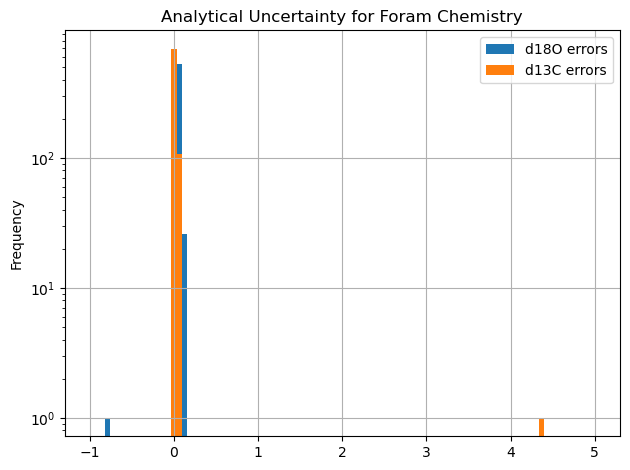

In [10]:
fig,ax=plt.subplots()
bins=np.linspace(-1,5,100)
benth['d18O_stdev'].hist(ax=ax,bins=bins,label='d18O errors')
benth['d13C_stdev'].hist(ax=ax,bins=bins,label='d13C errors')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_title('Analytical Uncertainty for Foram Chemistry')
plt.tight_layout()

In [11]:
benth=benth[(benth['d18O_stdev']>-.5)&(benth['d13C_stdev']<2)].copy()

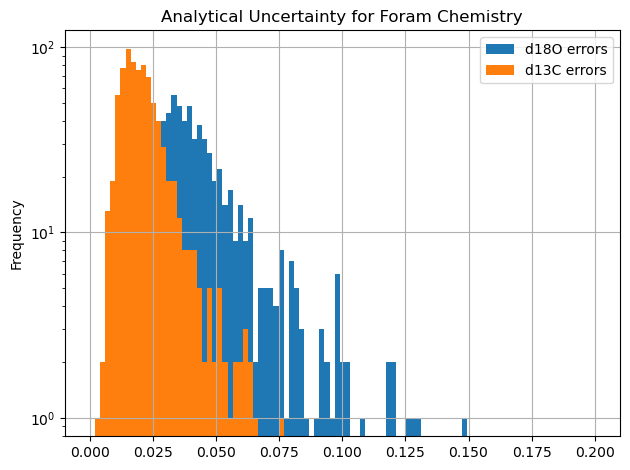

In [12]:
fig,ax=plt.subplots()
bins=np.linspace(0,.2,100)
benth['d18O_stdev'].hist(ax=ax,bins=bins,label='d18O errors')
benth['d13C_stdev'].hist(ax=ax,bins=bins,label='d13C errors')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_title('Analytical Uncertainty for Foram Chemistry')
plt.tight_layout()

### Quality controlled record with species separated

In [13]:
cib=benth[benth['benthic_species']=='cib'].copy()
uvi=benth[benth['benthic_species']=='uvi'].copy()

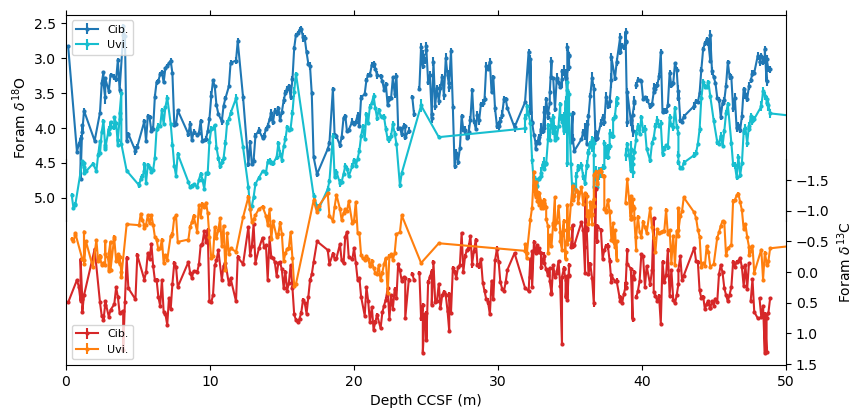

In [14]:
fig,axes=plt.subplots(figsize=(9,5),nrows=2,sharex=True)

sns.despine(ax=axes[0],top=False,bottom=True,right=False)
sns.despine(ax=axes[1],top=True,bottom=False,right=False)
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.tick_right()

for ax in [axes[0],axes[1]]:
    ax.patch.set_visible(False)

ax=axes[0]
cib.plot(x='Top depth CCSF (m)',y='d18O',yerr='d18O_stdev',ax=ax,color='tab:blue',label='Cib.',marker='o',ms=2)
uvi.plot(x='Top depth CCSF (m)',y='d18O',yerr='d18O_stdev',ax=ax,color='tab:cyan',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Foram $\delta^{18}$O')
ax.legend(fontsize=8,loc='upper left')

ax=axes[1]
cib.plot(x='Top depth CCSF (m)',y='δ13C',yerr='d13C_stdev',ax=ax,color='tab:red',label='Cib.',marker='o',ms=2)
uvi.plot(x='Top depth CCSF (m)',y='δ13C',yerr='d13C_stdev',ax=ax,color='tab:orange',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Foram $\delta^{13}$C')
ax.legend(fontsize=8,loc='lower left')

ax.set_xlabel('Depth CCSF (m)')
ax.set_xlim(0,50)

plt.subplots_adjust(hspace=-.3,top=.9,bottom=.2,left=.1,right=.9)
# fig.savefig(figure_path+'foram_chem.png',dpi=300)

## Correct Cibides $^{18}$O and Uvigerina $^{13}$C vital effects
Each species has biological processes that fractionate its isotopic chemistry from the isotopic chemistry of the seawater that it grew in. To unify our records, we need to fix these vital effects for each species
### Citations:

Shackleton, N.J., 1974. Attainment of isotopic equilibrium between ocean water andthe benthonic foraminifera genus Uvigerina: isotopic changes in the ocean duringthe  last  glacial.  Les.  Meth.  Quant.  D’etude  Var.  Clim.  Au  Cours  du  Pleist.,  Coll.  Int.CNRS, 219:203–209. 

Shackleton, N.J. and Opdyke, N., 1973. Oxygen iso- tope and palaeomagnetic stratigraphy of equa- torial Pacific core V28--238: oxygen isotope tem- peratures and ice volumes on a l0 s year and 106 year scale. Quaternary Res., 3: 39--55. 

Add 0.64 to 18O of Cibides to get to Uvigerina, which records seawater d18O faithfully between .8-7 &deg;C

Duplessy, J.-C., Shackleton, N.J., Matthews, R.K., Prell, W.L., Ruddiman, W.F., Caralp,M., and Hendy, C.H., 1984. 13C record of benthic foraminifera in the last intergla-cial ocean: implications for the carbon cycle and the global deep water circulation.Quat. Res., 21:225-243.  

d13 in Cibides is heavier than Uvigerina by 0.90 per mil. d13C in Cibides is close (+0.07 per mil) to seawater d13C

In [15]:
cib=benth[benth['benthic_species']=='cib'].copy()
uvi=benth[benth['benthic_species']=='uvi'].copy()

In [16]:
uvi['d18O_corrected']=uvi['d18O']
cib['d18O_corrected']=cib['d18O']+.64
uvi['d13C_corrected']=uvi['δ13C']+0.83
cib['d13C_corrected']=cib['δ13C']-.07

### Vital effect corrected d18O and d13C

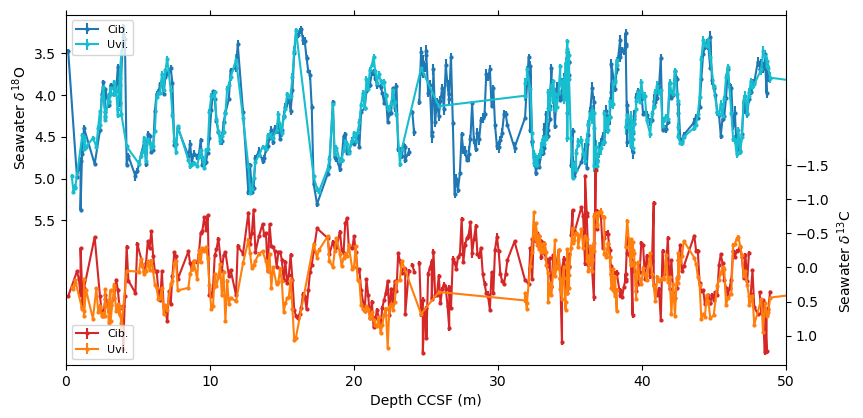

In [17]:
fig,axes=plt.subplots(figsize=(9,5),nrows=2,sharex=True)

sns.despine(ax=axes[0],top=False,bottom=True,right=False)
sns.despine(ax=axes[1],top=True,bottom=False,right=False)
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.tick_right()

for ax in [axes[0],axes[1]]:
    ax.patch.set_visible(False)

ax=axes[0]
cib.plot(x='Top depth CCSF (m)',y='d18O_corrected',yerr='d18O_stdev',ax=ax,color='tab:blue',label='Cib.',marker='o',ms=2)
uvi.plot(x='Top depth CCSF (m)',y='d18O_corrected',yerr='d18O_stdev',ax=ax,color='tab:cyan',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Seawater $\delta^{18}$O')
ax.legend(fontsize=8,loc='upper left')

ax=axes[1]
cib.plot(x='Top depth CCSF (m)',y='d13C_corrected',yerr='d13C_stdev',ax=ax,color='tab:red',label='Cib.',marker='o',ms=2)
uvi.plot(x='Top depth CCSF (m)',y='d13C_corrected',yerr='d13C_stdev',ax=ax,color='tab:orange',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Seawater $\delta^{13}$C')
ax.legend(fontsize=8,loc='lower left')

ax.set_xlabel('Depth CCSF (m)')
ax.set_xlim(0,50)

plt.subplots_adjust(hspace=-.3,top=.9,bottom=.2,left=.1,right=.9)
# fig.savefig(figure_path+'seawater_chem.png',dpi=300)

## Make figure

In [18]:
uvi.loc[1200,['Top depth CCSF (m)','d18O','d18O_corrected','δ13C','d13C_corrected']]=[30,
                                                                                      np.nan,np.nan,np.nan,np.nan]                                                                                

In [19]:
dcib=cib.set_index('Top depth CCSF (m)').sort_index()
duvi=uvi.set_index('Top depth CCSF (m)').sort_index()

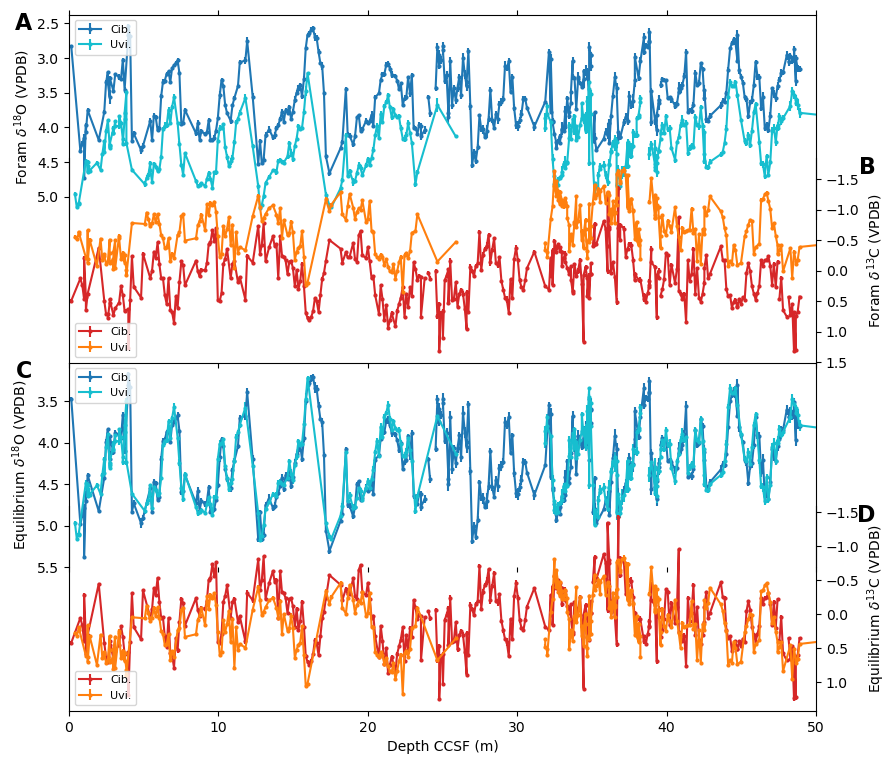

In [20]:
fig = plt.figure(figsize=(9,8),facecolor='white')
gs = gridspec.GridSpec(2, 1, figure=fig,hspace=0,top=.95,bottom=.08,left=.08,right=.91)
gsA = gs[0].subgridspec(2, 1,hspace=-.3)
gsB = gs[1].subgridspec(2, 1,hspace=-.3)

ax1 = fig.add_subplot(gsA[0])
ax2 = fig.add_subplot(gsA[1])
ax3 = fig.add_subplot(gsB[0])
ax4 = fig.add_subplot(gsB[1])
axes=[ax1,ax2,ax3,ax4]

sns.despine(ax=axes[0],top=False,bottom=True,right=False)
sns.despine(ax=axes[1],top=True,bottom=False,right=False)
sns.despine(ax=axes[2],top=True,bottom=True,right=False)
sns.despine(ax=axes[3],top=True,bottom=False,right=False)
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.tick_right()
axes[3].yaxis.set_label_position('right')
axes[3].yaxis.tick_right()

for ax in [axes[0],axes[1],axes[2],axes[3]]:
    ax.patch.set_visible(False)

ax=axes[0]
# cib.plot(x='Top depth CCSF (m)',y='d18O',yerr='d18O_stdev',ax=ax,color='tab:blue',label='Cib.',marker='o',ms=2)
dcib['d18O'].plot(yerr=dcib['d18O_stdev'],ax=ax,color='tab:blue',label='Cib.',marker='o',ms=2)
duvi['d18O'].plot(yerr=duvi['d18O_stdev'],ax=ax,color='tab:cyan',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Foram $\delta^{18}$O (VPDB)')
ax.legend(fontsize=8,loc='upper left')
ax.set_xticklabels([])
ax.set_xlabel('')

ax=axes[1]
dcib['δ13C'].plot(yerr=dcib['d13C_stdev'],ax=ax,color='tab:red',label='Cib.',marker='o',ms=2)
duvi['δ13C'].plot(yerr=duvi['d13C_stdev'],ax=ax,color='tab:orange',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Foram $\delta^{13}$C (VPDB)')
ax.legend(fontsize=8,loc='lower left')
ax.set_xticklabels([])
ax.set_xlabel('')

ax=axes[2]
dcib['d18O_corrected'].plot(yerr=dcib['d18O_stdev'],ax=ax,color='tab:blue',label='Cib.',marker='o',ms=2)
duvi['d18O_corrected'].plot(yerr=duvi['d18O_stdev'],ax=ax,color='tab:cyan',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Equilibrium $\delta^{18}$O (VPDB)')
ax.legend(fontsize=8,loc='upper left')
ax.set_xticklabels([])
ax.set_xlabel('')

ax=axes[3]
dcib['d13C_corrected'].plot(yerr=dcib['d13C_stdev'],ax=ax,color='tab:red',label='Cib.',marker='o',ms=2)
duvi['d13C_corrected'].plot(yerr=duvi['d13C_stdev'],ax=ax,color='tab:orange',label='Uvi.',marker='o',ms=2)
ax.invert_yaxis()
ax.set_ylabel('Equilibrium $\delta^{13}$C (VPDB)')
ax.legend(fontsize=8,loc='lower left')

axes[-1].set_xlabel('Depth CCSF (m)')
for ax in axes:
    ax.set_xlim(0,50)

letters=['A','C']
for i,ax in enumerate(axes[::2]):
    ax.annotate(letters[i],xy=(-.05,.9),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                fontsize=16)
letters=['B','D']
for i,ax in enumerate(axes[1::2]):
    ax.annotate(letters[i],xy=(1.08,.9),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                fontsize=16)

fig.savefig(sup_figure_path+'Extended Data Figure 2 - U1474 stable isotope data.png',dpi=300)

## Export

### Separate species

In [21]:
cib=benth[benth['benthic_species']=='cib'].copy()
uvi=benth[benth['benthic_species']=='uvi'].copy()

### Correct vital effects

In [22]:
uvi['d18O_corrected']=uvi['d18O']
cib['d18O_corrected']=cib['d18O']+.64
uvi['d13C_corrected']=uvi['δ13C']+0.83
cib['d13C_corrected']=cib['δ13C']-.07

### Calculate averages and error

In [23]:
benth['benthic d18O']=None
benth['benthic d13C']=None
benth['s d18O']=None
benth['s d13C']=None
benth[['benthic d18O','s d18O','benthic d13C','s d13C']]=(pd.concat([uvi,cib],axis=0)
                                                         .sort_index()[['d18O_corrected','d18O_stdev',
                                                                        'd13C_corrected','d13C_stdev']]).values

In [24]:
benth=benth.set_index('Top depth CCSF (m)',drop=False)

In [25]:
value_result=benth.groupby(by=benth.index)[['benthic d18O','benthic d13C']].mean()
error_result=benth.groupby(by=benth.index)[['s d18O','s d13C']].mean()
value_result['Species']=None
value_result.loc[benth.groupby(by=benth.index).size()>=2,'Species']='uvi & cib'
single_species=benth.loc[benth.groupby(by=benth.index).size()<2,'benthic_species']
value_result.loc[single_species.index,'Species']=single_species.values
result=pd.concat([value_result,error_result],axis=1)
result=result[['benthic d18O','s d18O','benthic d13C','s d13C','Species']].copy()

### Clean column names

In [26]:
col_list_now=['exp', 'site', 'hole', 'core_num', 'type', 'section', 'sec_half',
              'top_offset_cm', 'bottom_offset_cm','Top depth CCSF (m)', 'Bottom depth CCSF (m)']
col_list_final=['Exp','Site', 'Hole', 'Core', 'Type', 'Section', 'A/W', 
                'Top offset (cm)','Bottom offset (cm)','Top depth CCSF (m)','Bottom depth CCSF (m)']
result[col_list_final]=benth.loc[benth.index.duplicated()==False,col_list_now]

In [27]:
result=result[['Exp','Site', 'Hole', 'Core', 'Type', 'Section', 'A/W', 
               'Top offset (cm)','Bottom offset (cm)','Top depth CCSF (m)','Bottom depth CCSF (m)',
               'Species','benthic d18O','s d18O','benthic d13C','s d13C']]

In [37]:
result=result.drop(result[result['benthic d13C']>1].index)[result['Top depth CCSF (m)']<60]

In [39]:
result.to_csv(table_path+'Supplementary Table 1 - Benthic foram chemistry.csv',index=False)

## Species averaged record

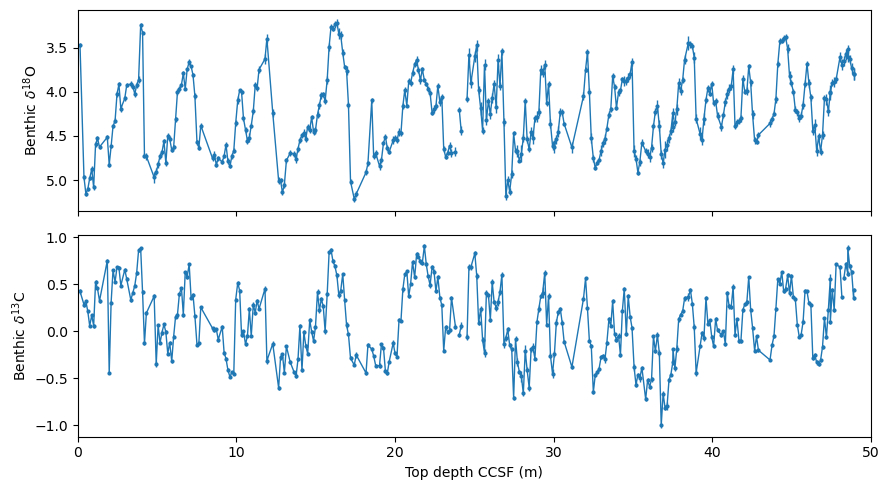

In [30]:
fig,axes=plt.subplots(nrows=2,figsize=(9,5),sharex=True)
ax=axes[0]
result.loc[:50,'benthic d18O'].plot(yerr=result.loc[:50,'s d18O'],ax=ax,lw=1,marker='o',ms=2)
ax.set_ylabel('Benthic $\delta^{18}$O')
ax.invert_yaxis()

ax=axes[1]
result.loc[:50,'benthic d13C'].plot(yerr=result.loc[:50,'s d13C'],ax=ax,lw=1,marker='o',ms=2)
ax.set_ylabel('Benthic $\delta^{13}$C')


ax.set_xlim(0,50)
plt.tight_layout()